In [31]:
import graphgen
from graphgen import data, generate
from graphgen.graph import Graph, Node
import numpy as np
import matplotlib.pyplot as plt

from fastdtw import fastdtw
from scipy.spatial.distance import euclidean

In [10]:
# Get data
path = "/Users/bkalisetti658/desktop/graphgen/data/InteractionDR1.0/recorded_trackfiles/DR_USA_Roundabout_EP"
box = [[960, 1015], [980, 1040]]
traces = data.get_training_data(1, path, box)
traces = data.clean(traces, 50, 1)

In [53]:
# Get node representation
trips = []
for trace in traces:
    trip = []
    for point in trace:
        node = Node(point[0], point[1], point[2])
        trip.append(node)
    trips.append(trip)

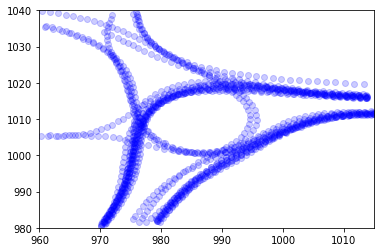

In [11]:
# Plot initial data
plt.figure(0)
plt.xlim(960, 1015)
plt.ylim(980, 1040)
for trace in traces:
    for point in trace:
        plt.scatter(point[0], point[1], c='b', alpha=0.2)
plt.show()

In [67]:
# Classify traces into lanes manually
# Discarded 0, 2
rl = [16]
rb = [1, 8, 11, 14, 15, 18, 19, 21, 24]
br = [6, 12, 13, 20, 22, 25, 26, 27]
tr = [7, 10]
rt = [3]
special = [4]
btl = [9]
bt = [23]

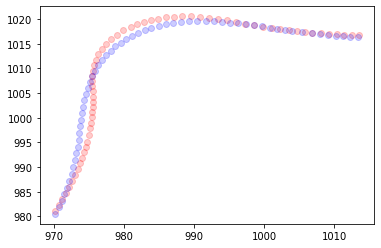

In [16]:
# Plot traces[1] and traces[8]
for point in traces[1]:
    plt.scatter(point[0], point[1], c='r', alpha=0.2)
for point in traces[8]:
    plt.scatter(point[0], point[1], c='b', alpha=0.2)

In [17]:
# Test dtw on traces[1] and traces[8]
x = np.array(traces[1])
y = np.array(traces[8])
x = x[:, :2]
y = y[:, :2]
distance, path = fastdtw(x, y, dist=euclidean)
print(distance)
print(len(path))
print(path)

55.52454341243118
64
[(0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15), (16, 16), (16, 17), (17, 18), (18, 19), (19, 20), (20, 21), (21, 22), (22, 23), (23, 24), (24, 25), (25, 26), (26, 26), (27, 27), (28, 28), (29, 29), (30, 30), (31, 31), (32, 32), (33, 33), (34, 34), (35, 35), (36, 36), (37, 37), (38, 38), (39, 39), (40, 40), (41, 40), (42, 41), (43, 42), (44, 43), (45, 44), (46, 45), (47, 45), (48, 46), (49, 47), (50, 48), (51, 49), (52, 50), (53, 51), (54, 51), (55, 52), (56, 53), (57, 54), (58, 55), (59, 56), (60, 57), (61, 58), (62, 59)]


In [64]:
# Get max/average distance for each pairing in dtw of traces[1] and traces[8]
avg_dist = 0
max_dist = -float('inf')
count = 0
for pair in path:
    one_point = traces[1][pair[0]]
    eight_point = traces[8][pair[1]]
    d = pow((one_point[0] - eight_point[0])**2 + (one_point[1] - eight_point[1])**2, 0.5)
    max_dist = max(max_dist, d)
    avg_dist += d
    count += 1
avg_dist /= count
print("Average distance: "+str(avg_dist))
print("Maximum distance: "+str(max_dist))

Average distance: 0.8675709908192372
Maximum distance: 1.601614810121308


In [65]:
def get_avg_and_max(trace1, trace2):
    """
    Compute average and max distances between two traces x and y
    """
    # Convert to usable form
    x = np.array(trace1)
    y = np.array(trace2)
    x = x[:, :2]
    y = y[:, :2]
    distance, path = fastdtw(x, y, dist=euclidean)

    avg_dist = 0
    max_dist = -float('inf')
    count = 0
    # Iterate through each pair, compute distance, update
    for pair in path:
        x = trace1[pair[0]]
        y = trace2[pair[1]]
        d = pow((x[0]-y[0])**2 + (x[1]-y[1])**2, 0.5)
        max_dist = max(max_dist, d)
        avg_dist += d
        count += 1
    avg_dist /= count
    return avg_dist, max_dist



In [66]:
# Get max/average distance for pairings of ALL rb traces
dist_limit = -float('inf')
for i in range(len(rb)):
    for j in range(i+1, len(rb)):
        index1 = rb[i]
        index2 = rb[j]

        avg_dist, max_dist = get_avg_and_max(traces[index1], traces[index2])
        dist_limit = max(dist_limit, avg_dist)
print(dist_limit)

3.9872360354712164


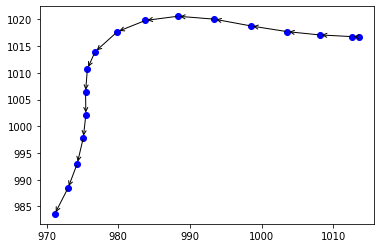

In [54]:
# Get rb graph using new dist_limit
rb_traces = [trips[i] for i in rb]
G = generate.convert_to_graph(rb_traces, dist_limit=dist_limit)
G.draw()

In [71]:
def compute_dist_limit(lane):
    """
    Compute dist_limit parameter for a lane (list of trace indices)
    """
    # Trivial case
    if len(lane) == 1:
        return 3
    dist_limit = -float('inf')
    for i in range(len(lane)):
        for j in range(i+1, len(lane)):
            index1 = lane[i]
            index2 = lane[j]

            avg_dist, max_dist = get_avg_and_max(traces[index1], traces[index2])
            dist_limit = max(dist_limit, avg_dist)
    return 2*dist_limit

0 3
1 2.4771141011890063
2 2.688875608049758
3 1.7854992260565121
4 3
5 3
6 3
7 3


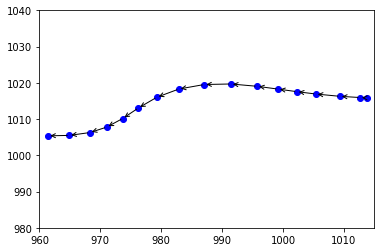

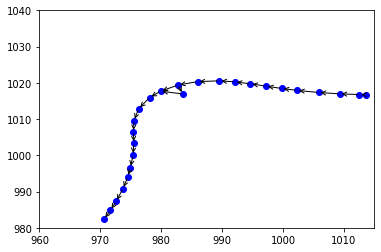

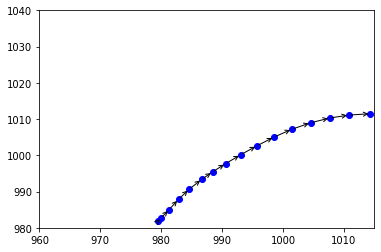

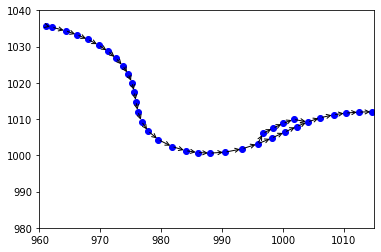

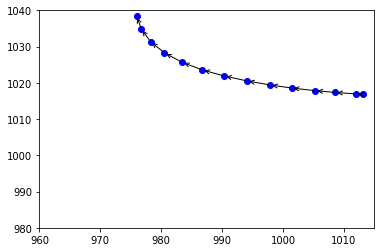

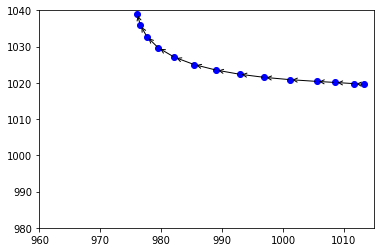

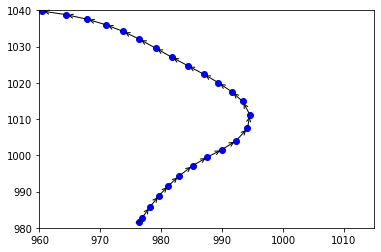

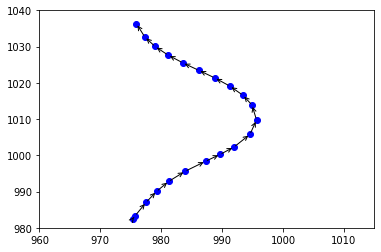

In [72]:
# Get dist_limits for each lane and compute to graph
lanes = [rl, rb, br, tr, rt, special, btl, bt]
for i in range(len(lanes)):
    lane = lanes[i]
    dist_limit = compute_dist_limit(lane)
    print(i, dist_limit)
    lane_trips = [trips[index] for index in lanes[i]]
    G = generate.convert_to_graph(lane_trips, dist_limit=dist_limit)
    plt.figure(i)
    plt.xlim(960, 1015)
    plt.ylim(980, 1040)
    G.draw()
    
